# Build Basic Chatbot

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [23]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model = "qwen/qwen3-32b")

In [9]:
## Node Functionality
def chatbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

In [10]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot", chatbot)

graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

##compile
graph = graph_builder.compile()

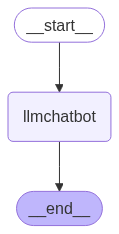

In [13]:
## Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
response = graph.invoke({"messages": "Hi"})

In [17]:
response["messages"][-1].content

'<think>\nOkay, the user said "Hi". I need to respond appropriately. Since it\'s a greeting, I should start with a friendly greeting of my own. Let me make sure to use an emoji to keep it warm and approachable. I should also offer assistance, so the user knows I\'m here to help if they need anything. Let me check for any typos and keep the tone positive. Alright, that should cover it.\n</think>\n\nHi! 😊 How can I assist you today? Let me know if you have any questions or need help with anything!'

In [19]:
for event in graph.stream({"messages": "Hi How are you?"}):
    # print(event)
    for value in event.values():
        print(value)

{'messages': [AIMessage(content="<think>\nOkay, the user is asking how I am. I need to respond in a friendly and open way. Since I'm an AI, I don't have emotions, but I can mention that I'm here and ready to help. Keep it casual and invite them to ask anything. Make sure the tone is warm and approachable.\n</think>\n\nI'm just a pile of code, but I'm here and ready to help! 😊 How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 13, 'total_tokens': 110, 'completion_time': 0.296292351, 'prompt_time': 0.105053245, 'queue_time': 0.045096035, 'total_time': 0.401345596}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--04e3ab12-8d9e-4282-a16e-62c44fb341ca-0', usage_metadata={'input_tokens': 13, 'output_tokens': 97, 'total_tokens': 110})]}


# Chatbot With Tool

In [24]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [31]:
def multiply(a: int, b: int) -> int:
    '''Multiplies two integers and returns the result.'''
    return a * b

In [33]:
tools = [tool, multiply]

In [34]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
#StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
# builder.add_edge("tools", END)
builder.add_edge("tools", "tool_calling_llm")


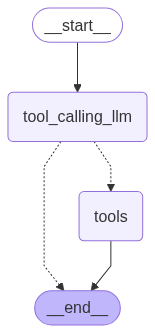

In [36]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
graph.invoke({"messages": "What is the recent ai news"})

{'messages': [HumanMessage(content='What is the recent ai news', additional_kwargs={}, response_metadata={}, id='51fd82d8-c41d-42b1-a68f-3ae8a6c4a09b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me check which tool to use. They mentioned "recent," so I should consider the time_range parameter. The available functions are tavily_search and multiply. Multiply is for math, so tavily_search is the right choice.\n\nFor tavily_search, the parameters include time_range, which can be set to "day," "week," "month," or "year." Since the user wants recent news, maybe "week" is appropriate to get the latest updates without being too narrow. Also, the topic parameter can be set to "news" if it\'s about current events. Wait, the topic parameter\'s description says to use "news" for politics, sports, or major events covered by mainstream media. AI news might be considered general, so maybe leave topic as "general" and use time_ra

In [38]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

<think>
Okay, the user said "Hi". I need to respond appropriately. Since it's a greeting, I should start with a friendly greeting of my own. Let me make sure to use an emoji to keep it warm and approachable. I should also offer assistance, so the user knows I'm here to help if they need anything. Let me check for any typos and keep the tone positive. Alright, that should cover it.
</think>

Hi! 😊 How can I assist you today? Let me know if you have any questions or need help with anything!
